**Brian Blaylock**
**30 January 2019**

# Does a point lie inside a contour?
This is a question I need to answer with the GOES-16 Geostationary Lightning Product and HRRR lightning product.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from shapely.geometry import Polygon, Point # am I using this?

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/')
from BB_HRRR.HRRR_Pando import get_hrrr_variable, get_hrrr_latlon
from BB_maps.my_basemap import draw_HRRR_map, draw_centermap, draw_GLM_map, draw_CONUS_cyl_map
from BB_GOES.get_GLM import get_GLM_file_nearesttime, accumulate_GLM

In [2]:
lat, lon = get_hrrr_latlon(DICT=False)

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Draw mercator projection HRRR map
mc = draw_CONUS_cyl_map()

In [4]:
# Draw GLM map
mg = draw_GLM_map()

In [5]:
# Draw HRRR basemap object
m = draw_HRRR_map()

In [6]:
# Draw a small domain map
m1 = draw_centermap(40, -110, size=(5.5,5.5))

In [7]:
# Retrieve HRRR data
VAR = 'LTNG:entire'
DATE = datetime(2018, 5, 14, 22)

HH = [get_hrrr_variable(DATE-timedelta(hours=fxx), VAR, fxx=fxx, value_only=True, verbose=False) for fxx in range(0,19)]

#fxx = 12
#H_12 = get_hrrr_variable(DATE-timedelta(hours=fxx), VAR, fxx=fxx)
#
#fxx = 6
#H_06 = get_hrrr_variable(DATE-timedelta(hours=fxx), VAR, fxx=fxx)

In [8]:
files = get_GLM_file_nearesttime(DATE-timedelta(minutes=30), window=90, verbose=False)
g = accumulate_GLM(files)

99.4% Complete (180 of 181) : 2018-05-14 22:00:00

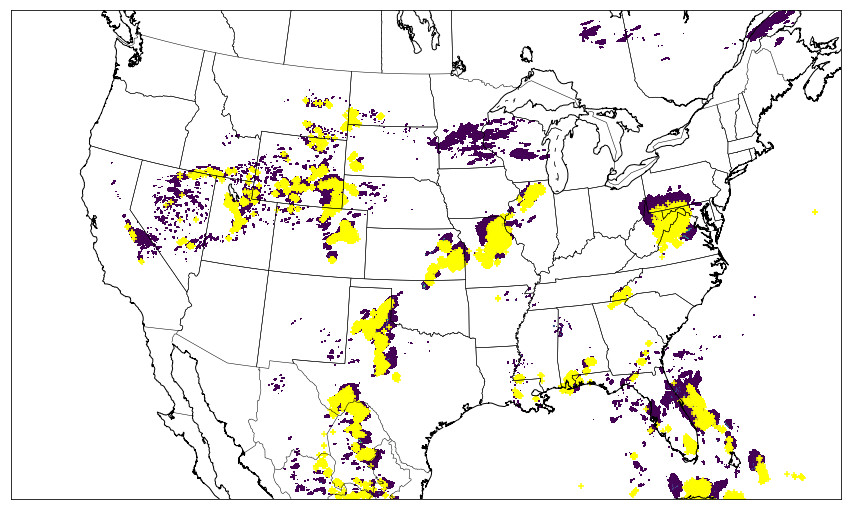

In [13]:
plt.figure(figsize=(20,9))

m.pcolormesh(lon, lat, HH[1]['value'], latlon=True)
m.scatter(g['longitude'], g['latitude'], marker='+', c='yellow', latlon=True)
#m.scatter(pt_lon, pt_lat, latlon=True)

m.drawcountries()
m.drawstates()
m.drawcoastlines()

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


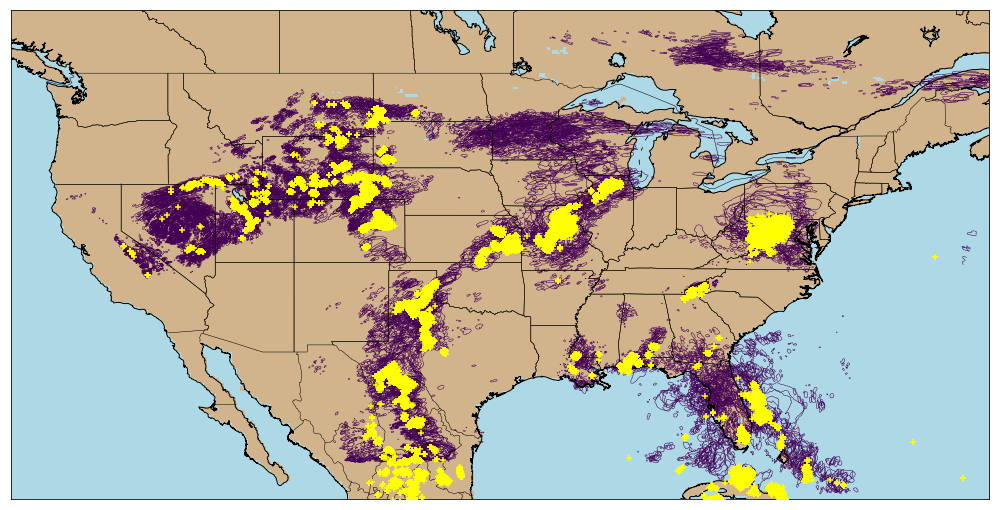

In [16]:
plt.figure(figsize=(20,9))

ltng = {'c_objects':[]}
for H in HH:
    c = mc.contour(lon, lat, H['value'].data, latlon=True, levels=[0], zorder=1, linewidths=.5)
    ltng['c_objects'].append(c)

s = mc.scatter(g['longitude'], g['latitude'], marker='+', c='yellow', zorder=10)

mc.drawlsmask(land_color='tan',ocean_color='lightblue',lakes=True)
mc.drawcountries()
mc.drawstates()
mc.drawcoastlines()


In [515]:
c06.collections

<a list of 1 mcoll.LineCollection objects>

In [20]:
[len(c.collections[0].get_paths()) for c in ltng['c_objects']]

[0,
 1812,
 1075,
 849,
 832,
 814,
 744,
 791,
 752,
 695,
 703,
 785,
 753,
 711,
 651,
 741,
 723,
 777,
 789]

In [22]:
ltng['largest'] = []
for coll in ltng['c_objects']:
    largest = 0
    for i, C in enumerate(coll.collections[0].get_paths()):
        if len(C) > largest:
            largest = i
    ltng['largest'].append(largest)

In [24]:
# Index
ltng['largest']

[0,
 804,
 872,
 693,
 434,
 450,
 610,
 652,
 657,
 398,
 375,
 354,
 378,
 387,
 383,
 451,
 441,
 493,
 520]

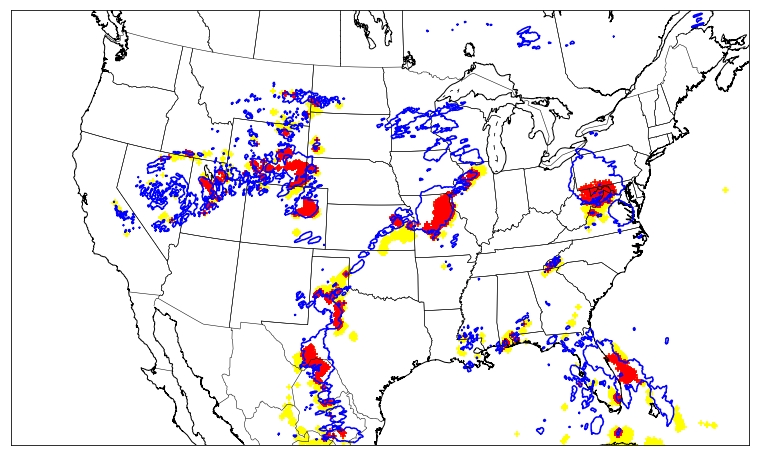

In [572]:
g['inside'] = np.zeros_like(g['latitude'])
g_latlon_pair = [(g['longitude'][i], g['latitude'][i]) for i in range(len(g['latitude']))]

plt.figure(figsize=(20,8))

for V in c06.collections[0].get_paths():
    try:
        v = V.vertices
        y = v[:,0]
        x = v[:,1]
        #poly = Polygon([(i[0], i[1]) for i in zip(x,y)])
        #x,y = poly.exterior.xy
        m.plot(y,x, latlon=True, color='blue')
        
        inside = V.contains_points(g_latlon_pair)
        g['inside']+=inside
        
    except:
        pass

m.scatter(g['longitude'], g['latitude'], marker='+', c='yellow', latlon=True)
m.scatter(g['longitude'][g['inside']>0], g['latitude'][g['inside']>0], marker='+', c='red', latlon=True)
m.drawstates()
m.drawcoastlines()
m.drawcountries()

In [573]:
print(' total flashes in bounds:', sum(g['inside']))
print(' total flashes in domain:', len(g['latitude']))
print('percentage inside bounds: %.1f%%' % (100*sum(g['inside'])/len(g['latitude'])))

 total flashes in bounds: 17024.0
 total flashes in domain: 46575
percentage inside bounds: 36.6%


In [526]:
H['lat'].min(), H['lat'].max()

(21.138123000000004, 52.61565330680793)

In [545]:
index_bound_lat = np.logical_and(g['latitude']>H['lat'].min(), g['latitude']<H['lat'].max())
index_bound_lon = np.logical_and(g['longitude']>H['lon'].min(), g['longitude']<H['lon'].max())
bound = np.logical_and(index_bound_lat, index_bound_lon)

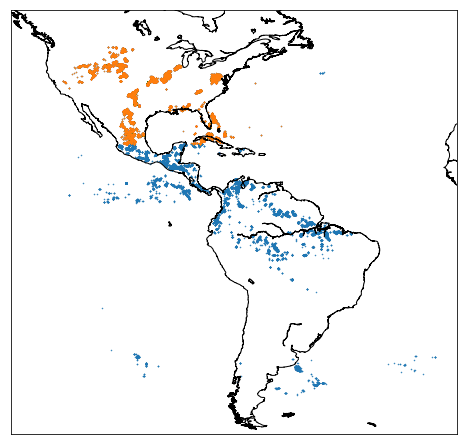

In [547]:
plt.figure(figsize=(8,8))
mg.scatter(g['longitude'], g['latitude'], marker='.', s=1)
mg.scatter(g['longitude'][bound], g['latitude'][bound], marker='.', s=1)

mg.drawcoastlines()

g['latitude'] = g['latitude'][bound]
g['longitude'] = g['longitude'][bound]

In [540]:
g['longitude'][index_bound_lat]

array([-102.2857666 , -101.82035065,  -80.86169434, ..., -102.66280365,
        -78.50562286,  -80.89463043])

In [537]:
index_bound_lat

array([29.36071587, 29.10217094, 23.72326851, ..., 29.69663048,
       22.66511154, 23.64752769])